# 06 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data


### 1. Importing your libraries and data

In [319]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
import nasdaqdatalink

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [320]:
# Configure API key and import the data

nasdaqdatalink.ApiConfig.api_key = 'NxQ2EyPwJp8bv4KeQYtY'

data = nasdaqdatalink.get_table('NDAQ/RTAT10', ticker='NVDA')

In [321]:
data.head()

,date,ticker,activity,sentiment
None,,,,
0,2024-08-02,NVDA,0.1304,1
1,2024-08-01,NVDA,0.1486,2
2,2024-07-31,NVDA,0.1555,2
3,2024-07-30,NVDA,0.1726,0
4,2024-07-29,NVDA,0.1110,0


In [322]:
data.shape

(1464, 4)

In [323]:
data.columns

Index(['date', 'ticker', 'activity', 'sentiment'], dtype='object')

**Ticker**
The abbreviation that identifies a stock. Here it is only NVDA for Nvidia. 

**Activity**
Ratio of USD traded by retail investors in a given ticker divided by total USD traded by retail investors across all tickers. This field has a value that ranges from 0 to 1.

**Sentiment** 
Sentiment score derived from the retail net flows (buy-sell) of the most recent 10 trading days. This field has a value that ranges from +100 to -100, whereby the more positive (negative) the score, the greater the proportion of recent retail net buying (selling).

In [325]:
type(data)

pandas.core.frame.DataFrame

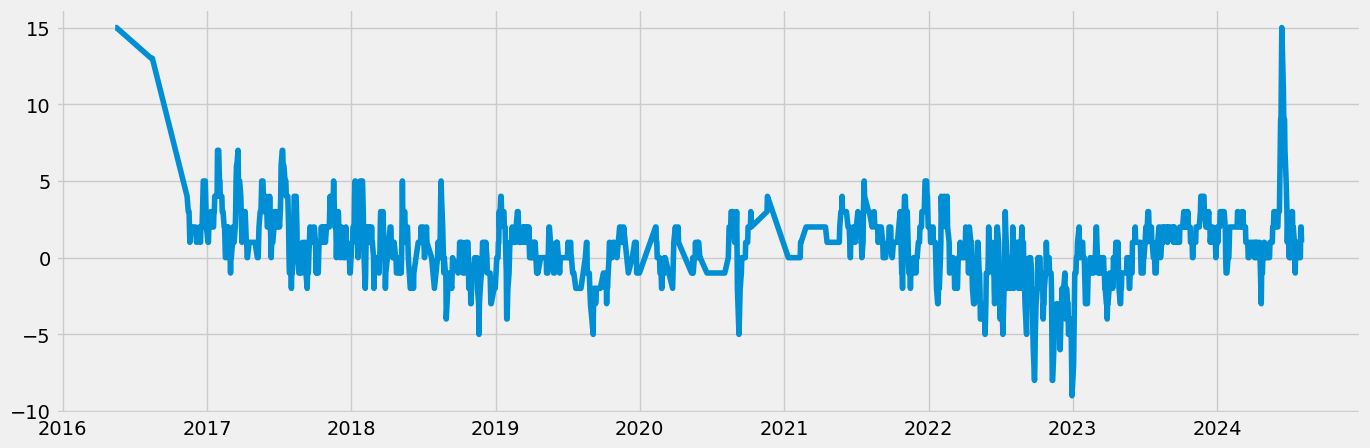

In [326]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data['date'], data['sentiment'], label='Sentiment')


This chart shows the "sentiment" or how optmistic are people to buy more stocks. A positive number means that traders are buying and a negative number means that people are selling.

### 2. Subsetting, wrangling, and cleaning time-series data

In [329]:
data_sub = data.loc[(data['date'] >= '2022-07-01')]

In [330]:
data_sub.shape

(525, 4)

In [331]:
data_sub.head()

,date,ticker,activity,sentiment
None,,,,
0,2024-08-02,NVDA,0.1304,1
1,2024-08-01,NVDA,0.1486,2
2,2024-07-31,NVDA,0.1555,2
3,2024-07-30,NVDA,0.1726,0
4,2024-07-29,NVDA,0.1110,0


In [332]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,ticker,activity,sentiment
datetime,,,
2024-08-02,NVDA,0.1304,1
2024-08-01,NVDA,0.1486,2
2024-07-31,NVDA,0.1555,2
2024-07-30,NVDA,0.1726,0
2024-07-29,NVDA,0.1110,0


In [333]:
data_sub.columns

Index(['ticker', 'activity', 'sentiment'], dtype='object')

In [334]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

ticker       0
activity     0
sentiment    0
dtype: int64

In [335]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

30

In [336]:
data_sub.drop_duplicates()

,ticker,activity,sentiment
datetime,,,
2024-08-02,NVDA,0.1304,1
2024-08-01,NVDA,0.1486,2
2024-07-31,NVDA,0.1555,2
2024-07-30,NVDA,0.1726,0
2024-07-29,NVDA,0.1110,0
...,...,...,...
2022-07-08,NVDA,0.0418,-5
2022-07-07,NVDA,0.0392,-4
2022-07-06,NVDA,0.0399,-2


In [337]:
# keep only data and activity
data_sub.reset_index(inplace = True)


data_sub = data_sub[['datetime', 'sentiment']]
data_sub['datetime'] = pd.to_datetime(data_sub['datetime'])
data_sub = data_sub.set_index('datetime')
data_sub = data_sub.sort_index()

data_sub.head()

,sentiment
datetime,
2022-07-01,-4
2022-07-05,-2
2022-07-06,-2
2022-07-07,-4
2022-07-08,-5


### 3. Time-series analysis: decomposition

In [339]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period = 12)

In [340]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

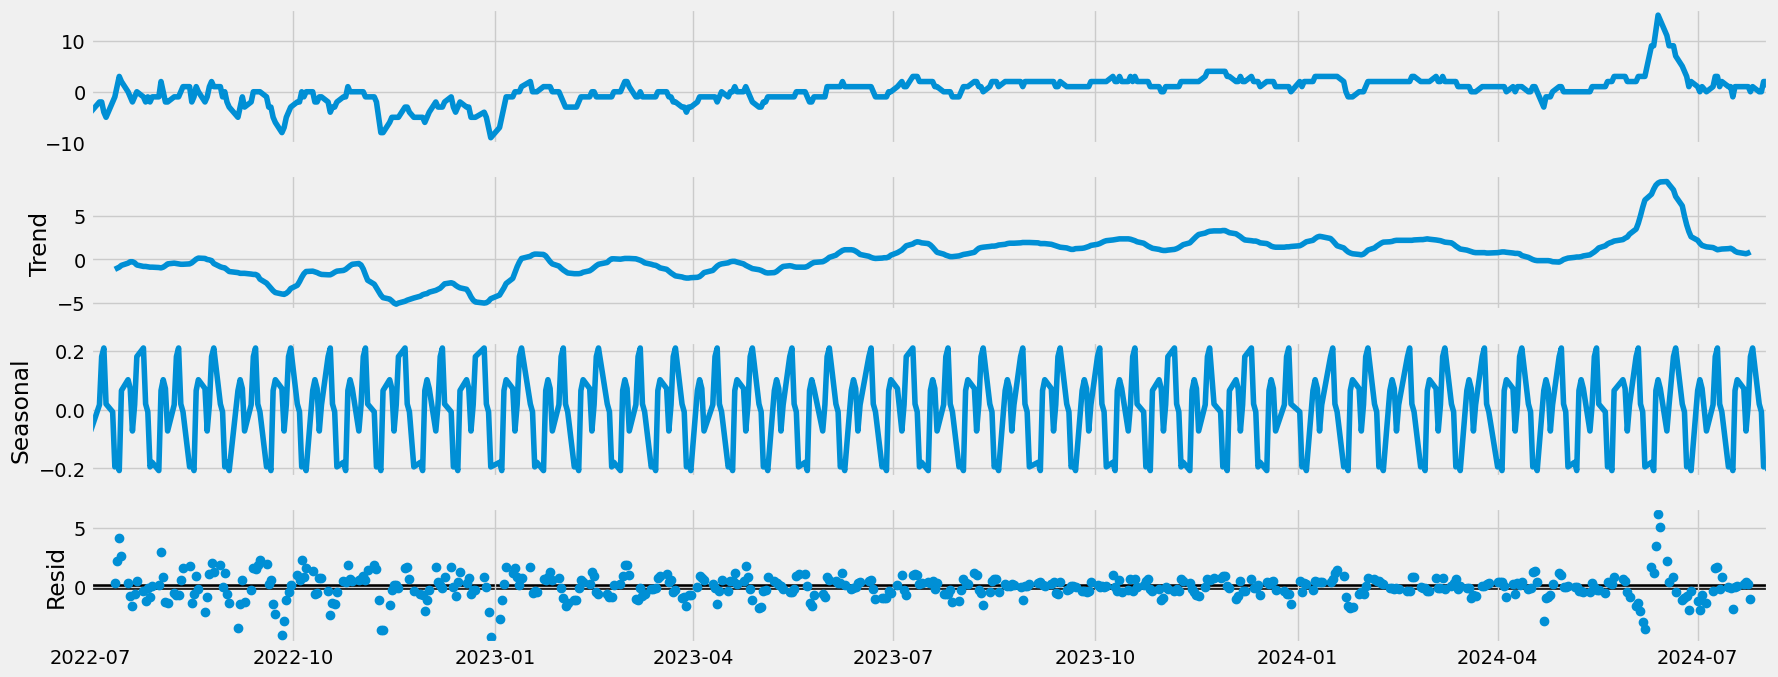

In [341]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

**Null hypothesis:** There is not a unit root (random jump) in the data. 

In [404]:
# import the adfuller function to perform a Dickey fuller test

from statsmodels.tsa.stattools import adfuller 

# define the dickey fuller function

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['sentiment'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.623875
p-value                          0.088163
Number of Lags Used             15.000000
Number of Observations Used    509.000000
Critical Value (1%)             -3.443263
Critical Value (5%)             -2.867235
Critical Value (10%)            -2.569803
dtype: float64


p value 0.08 which is higher (but very close) to 0.05. 

**If the test statistic is smaller, then you can reject the null hypothesis**
Taking in account a critical value of 5%
-2.62 > -2.86

Test statistic > critical value

Therefore we can't reject the null hypothesis. This means that there is a unit root in the data. Which means that it isn't stationary.

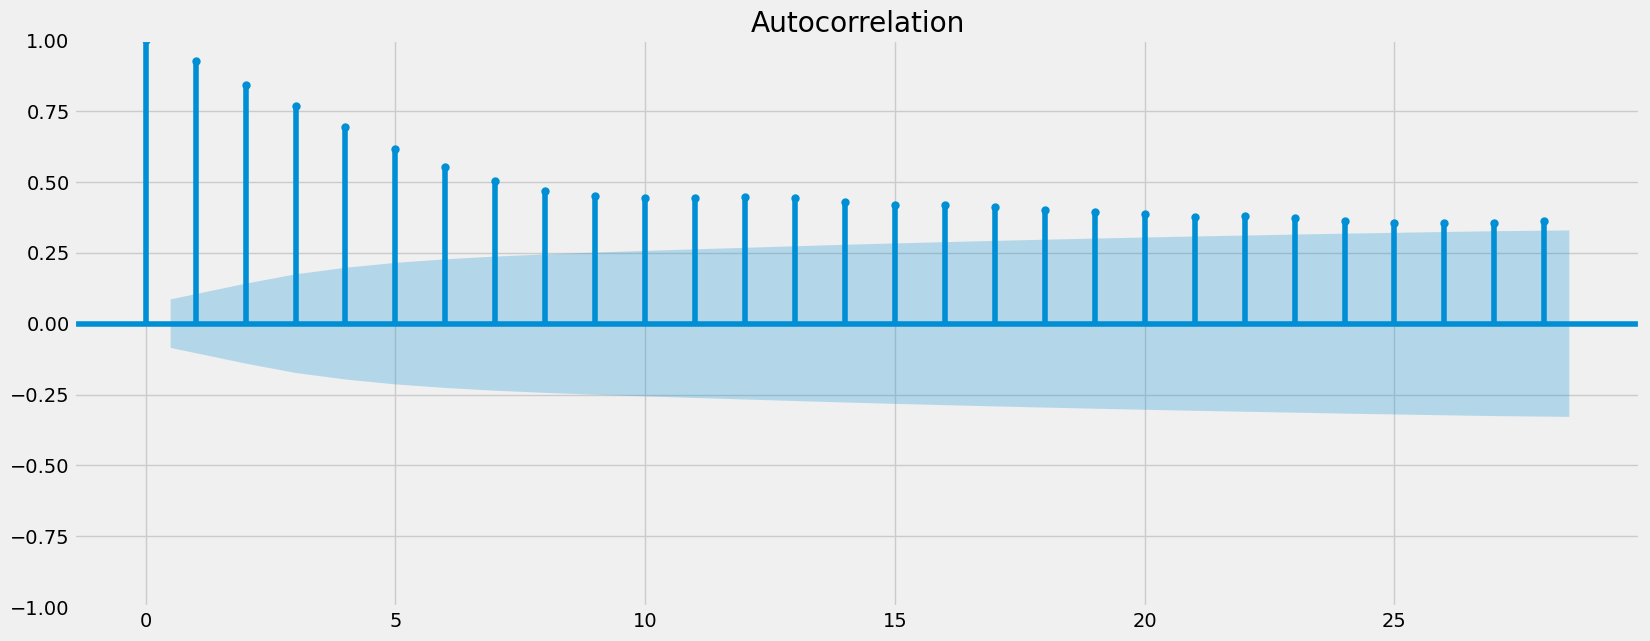

In [409]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

Having the lines outside of the blue area means that there are lags which have significant correlation. This confirms that the data is non-stationary. 

### 5. Stationarizing the data

In [388]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [390]:
data_diff.dropna(inplace = True) # remove the missing values that came about as a result of the differencing. 


In [392]:
data_diff.head()

,sentiment
datetime,
2022-07-05,2.0
2022-07-06,0.0
2022-07-07,-2.0
2022-07-08,-1.0
2022-07-11,3.0


In [394]:
data_diff.columns

Index(['sentiment'], dtype='object')

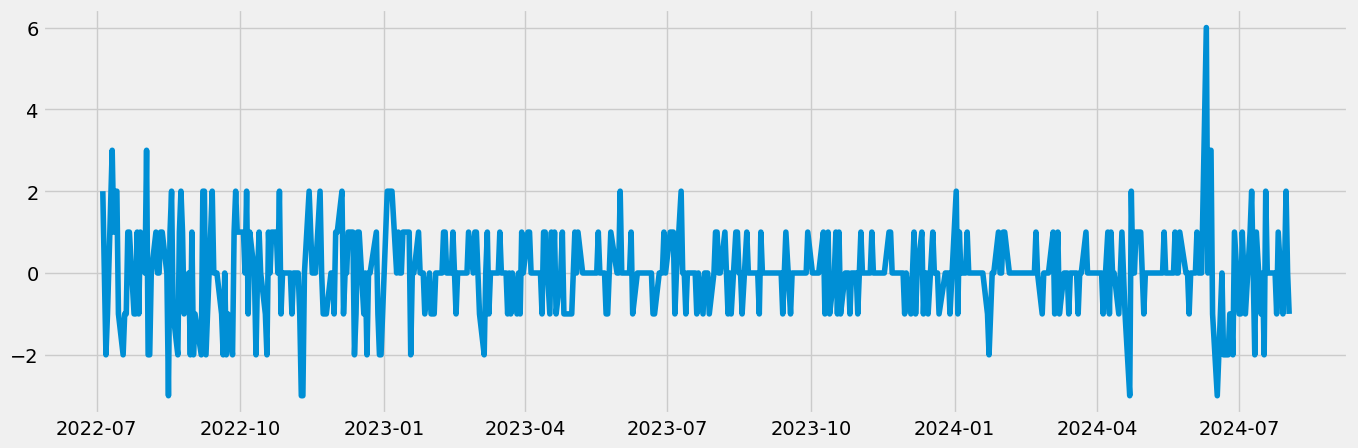

In [396]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [398]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.464068e+00
p-value                        1.539379e-13
Number of Lags Used            1.400000e+01
Number of Observations Used    5.090000e+02
Critical Value (1%)           -3.443263e+00
Critical Value (5%)           -2.867235e+00
Critical Value (10%)          -2.569803e+00
dtype: float64


Having the test statistic be smaller than the critical value, we can be sure that the null hypothesis is true.

**Null hypothesis:** There is not a unit root (random jump) in the data. 


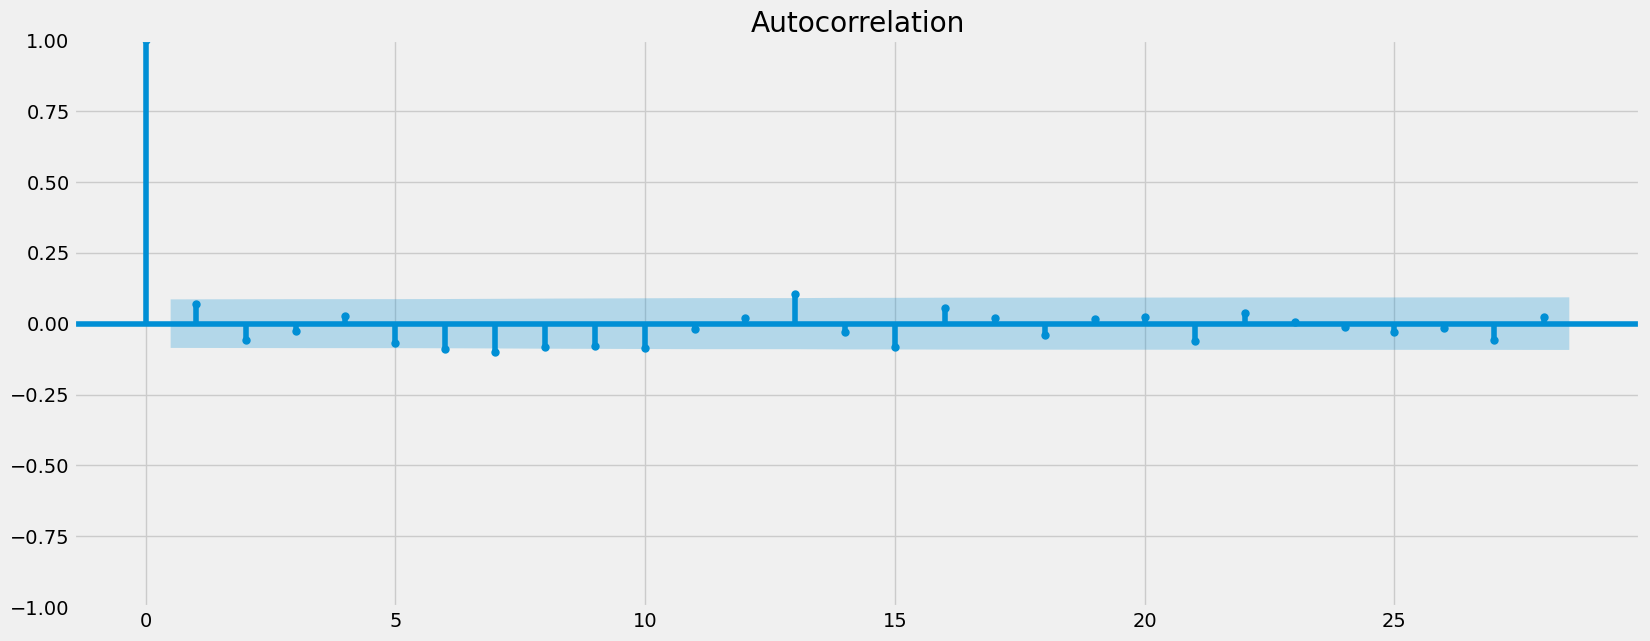

In [400]:
plot_acf(data_diff)
plt.show()